# TP 3 : introduction aux Graph Neural Networks

Les _Graph Neural Networks_ tentent de proposer des généralisations des modèles classiques d'apprentissage profond à des données irrégulières, et de permettre aux modèles neuronaux de raisonner à propos d'objets et de leurs interactions.

Cela repose sur un framework de _passage de messages (neural)_, où les caractéristiques d'un nœud $v \in \mathcal{V}$ (du graphe $\mathcal{G} = (\mathcal{V}, \mathcal{E})$), dans le vecteur $\mathbf{x}_v^{(\ell)}$sont mises à jour de façon interactive, par agrégation de l'information locale venant des voisins ($\mathcal{N}(v)$) :
$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

Dans cette séance, nous allons voir quelques concepts liés aux GNNs, au travers de la prise en main de la bibliothèque [PyTorch Geometric (PyG)](https://github.com/rusty1s/pytorch_geometric), une extension de PyTorch qui regroupe de nombreuses méthodes (et données) utiles pour traiter des GNNs.

In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 35.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 17.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 41.7 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-rde760tn
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-rde760tn
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 36aed7c28140a54f27aea6c2429636ff0d1c84b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.7 MB/s eta 0:00:00
  Created wh

In [2]:
%matplotlib inline
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Données graphes

Dans la lignée de l'article fondateur des GNns de Kipf et Welling ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), nous allons commencer avec le graphe du club de Karaté ([Zachary's karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)). C'est un réseau social de 34 personnes pratiquant le karaté, reliées si elles se connaissaient en dehors du club. Il est très utilisé dans le contexte de la détection de communautés, ce que nous allons regarder.

PyTorch geometric simplifie l'accès au dataset, grâce à un sous-package ([`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets)).

Regardons les données :

In [3]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Nombre de graphes: {len(dataset)}')
print(f'Nombre d\'attributs: {dataset.num_features}')
print(f'Number de classes: {dataset.num_classes}')

Dataset: KarateClub():
Nombre de graphes: 1
Nombre d'attributs: 34
Number de classes: 4


Les classes sont les "communautés" identifiées dans le dataset.

### Statistiques descriptives

Avec un peu plus de détails :

In [4]:
data = dataset[0]  # On prend le premier graphe (il n'y en a qu'un)

print(data)
print('==============================================================')

# stats.
print(f'Nœuds : {data.num_nodes}')
print(f'Arêtes : {data.num_edges}')
print(f'Degré moyen : {data.num_edges / data.num_nodes:.2f}')
print(f'Nœuds d\'apprentissage : {data.train_mask.sum()}')
print(f'Fraction de nœuds en apprentissage : {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Présence de nœuds isolés : {data.contains_isolated_nodes()}')
print(f'Présence de boucle : {data.contains_self_loops()}')
print(f'Est non-dirigé : {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Nœuds : 34
Arêtes : 156
Degré moyen : 4.59
Nœuds d'apprentissage : 4
Fraction de nœuds en apprentissage : 0.12
Présence de nœuds isolés : False
Présence de boucle : False
Est non-dirigé : True


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Chaque graphe dans PyTorch Geometric est représenté dans un objet [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). On peut afficher ces données avec `print(data)`, pour obtenir un résumé des attributs et de leurs formes.

On peut voir ici que le graphe est représenté par 4 attributs :
- `edge_index`, qui contient l'information sur les arêtes du graphe, sous la forme de tuples (index_noeud_source, index_noeud_destination) pour chaque arête
- `x`, les caractéristiques des nœuds (chacun des 34 nœuds se voit assigner un vecteur de dimension 34)
- `y`, les étiquettes des nœuds (ici, chaque nœud est affecté dans une classe/communauté)
- `train_mask`, un attribut qui précise pour quels nœuds nous connaissons leurs affectation en classes.

Ici, nous connaissons l'affectation de 4 sommets (un par classe), l'objectif est d'inférer l'affectation des autres.

L'objet `data` propose aussi des fonctions utiles, pour accéder à des propriétés classiques de graphes : est-ce qu'il existe des nœuds isolés, est-ce que le graphe contient des boucles, est-ce que le graphe est dirigé ou non.

Vous pouvez regarder l'`edge_index` un peu plus en détail.

In [5]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

Le format utilisé est appelé "format COO", régulièrement utilisé pour les matrices creuses. On ne stocke que les coordonnées (et les valeurs) non nulles.

### Visualisation simple

Pour visualiser le graphe, nous allons le convertir dans le format d'une bibliothèque Python bien connue pour gérer et afficher les graphes, `networkx`.

In [6]:
# Helper function for visualization.
def visualize(h, color, labels=None, wlabels=False, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), labels=None, with_labels=wlabels,
                         node_color=color, cmap="Set2")
    plt.show()


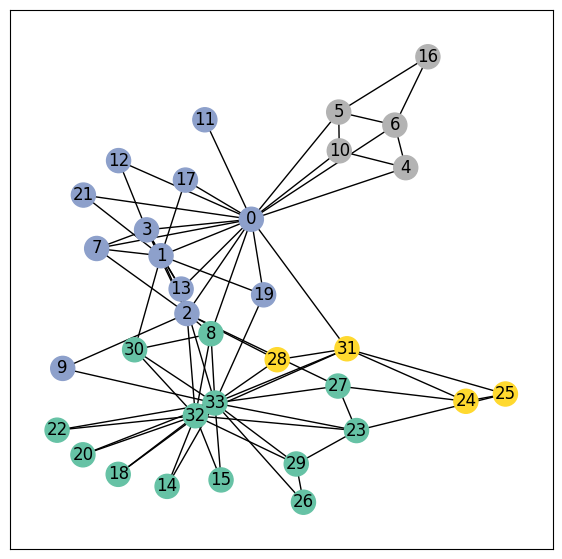

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y,wlabels=True)

## Implémenter des GNNs

### Premier modèle

Pour implémenter notre premier GNN, nous allons utiliser une des couches les plus simples, appelée GCN (ou GCNconv, voir [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), que l'on définit ainsi :

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

où $\mathbf{W}^{(\ell + 1)}$ est la matrice de poids apprise, de dimensions `[num_output_features, num_input_features]` et $c_{w,v}$ est un coefficient de normalisation fixé pour chaque arête.

PyG implémente cette couche avec [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), que l'on peut exécuter en lui passant la représentation `x` des attributs des nœuds et la représentation COO du graphe, `edge_index`.

On peut ainsi créer un premier GNN, en définissant l'architecture de notre réseau dans une classe `torch.nn.Module` :

In [8]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


On commence par initialiser tous nos blocs dans le `__init__`, et on détaille le flux d'exécution de notre réseau dans le `forward`.

On définit et empile 3 couches de convolution, ce qui revient à agréger l'information du voisinage jusqu'à la distance 3 dans le graphe. Ces couches réduisent également la dimension des représentations `x` à 2 ($34 \rightarrow 4 \rightarrow 4 \rightarrow 2$). Chaque couche `GCNConv` est complété par une non linéarité de tangente hyperbolique ([tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh)).

Ensuite, on utilise une couche linéaire ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) qui agit comme un classifieur pour affecter nos nœuds dans l'une de nos 4 classes. On retourne la sortie de ce classifieur, ainsi que l'embeding final de chacun des nœuds dans le GNN.

On termine initialisant le modèle et en en affichant un résumé.

### Les embeddings du graphe Karate Club

Visualisons un peu les embeddings générés pour nos données. Comme indiqué, on passe en paramètre les features initiales (`x`) et le `edge_index`.

In [9]:
model = GCN()
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [34, 2]


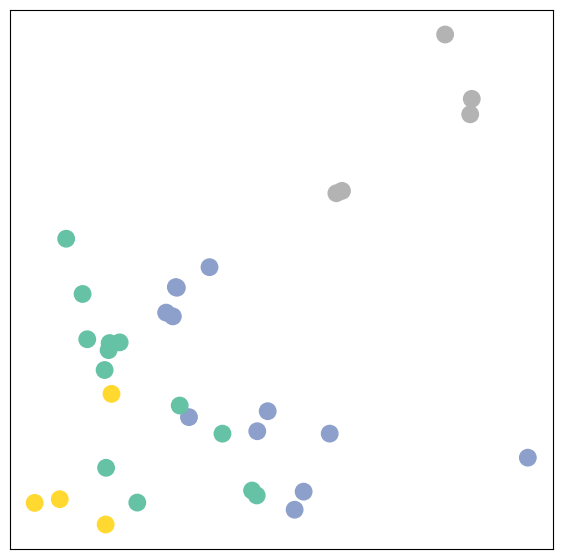

In [10]:
visualize(h, color=data.y)

**Question :** Que constatez-vous ?

Bien qu'on soit avant l'entraînement (avec donc des poids aléatoire), le modèle produit déjà des embeddings proches de la structure communautaire du graphe. Les nœuds de la même couleur sont proches dans l'espace des embeddings : les GNN amènent un biais inductif assez fort, avec des embeddings très similaires pour des nœuds proches dans le graphe initial.

### Entraînons notre GNN

Comme nous disposons de la vérité terrain (_ground truth_) pour un nœud dans chaque communauté, on peut essayer d'entraîner notre réseau avec cette information et de voir comment les embeddings évoluent.

On s'en remet à une procédure semi-supervisée : on s'entraîne avec seulement un nœud par classe mais l'on peut utiliser l'information complète sur la connectivité du graphe.

L'entraînement à réaliser est très proche de l'entraînement d'autres modèles en PyTorch.

Outre la définition du modèle, il nous faut définir une fonction de perte. Ici, on utilisera l'entropie croisée ([`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)), que l'on initialise à l'aide d'un optimiseur stochastique ([`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).

On procède ensuite à plusieurs étapes d'optimisation, chacune consistant en une passe _forward_ et une passe _backward_ (où l'on calcule les gradients des paramètres du modèle en fonction de la loss résultant de la passe _forward_). Voir cette [introduction à l'entraînement en PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer), si vous avez besoin de rappels.

La partie semi-supervisée est réalisée sur la ligne

```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```

Alors qu'on clacule les embeddings pour tous les nœuds, on n'utilise que les nœuds d'entraînement pour calculer la loss. On l'implémente en filtrant la sortie du classifieur `out` et les étiquettes de `data.y` pour ne contenir que les nœuds de `train_mask`.

Lançons maintenant l'entraînement, et regardons comment évoluent les embeddings.

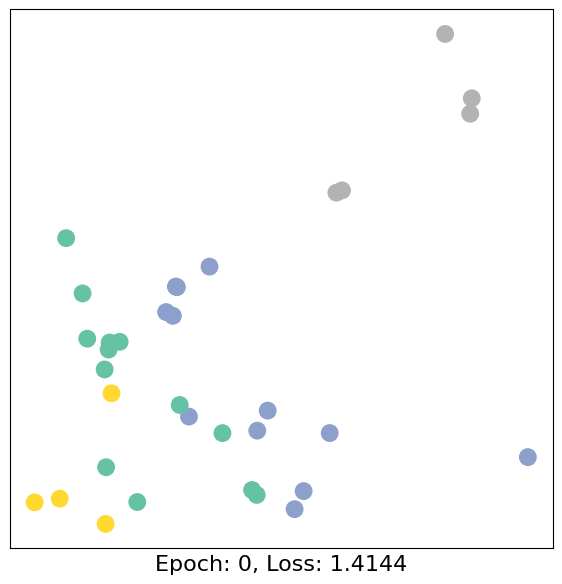

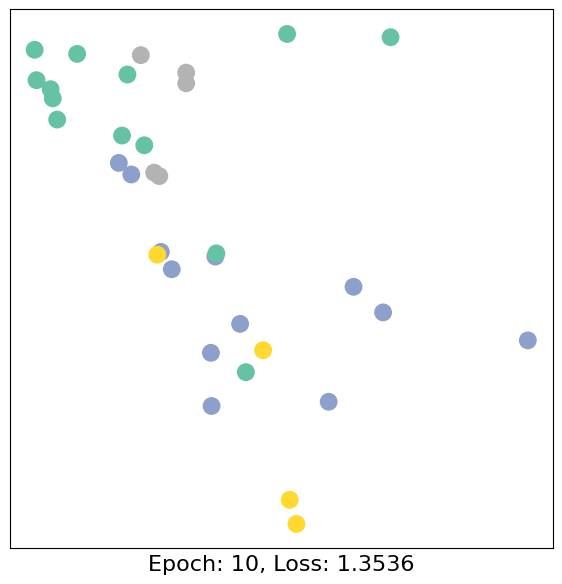

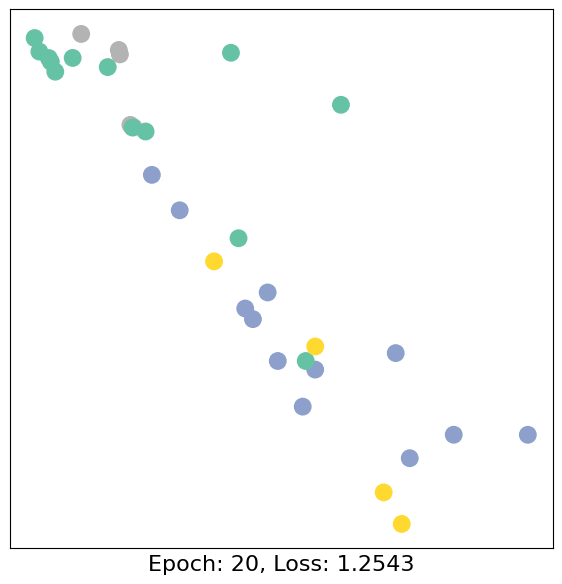

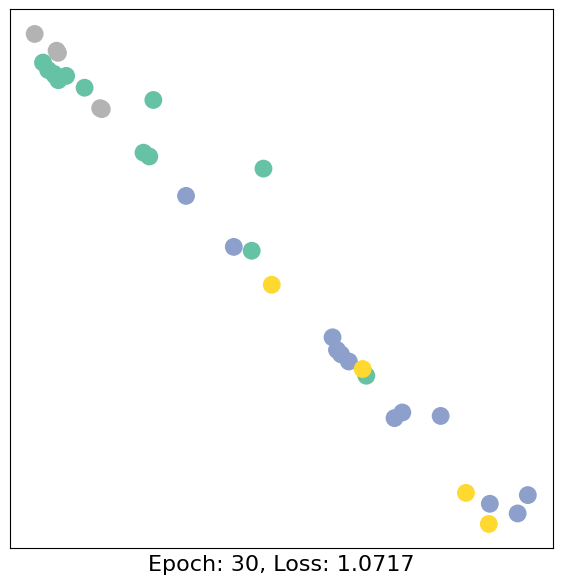

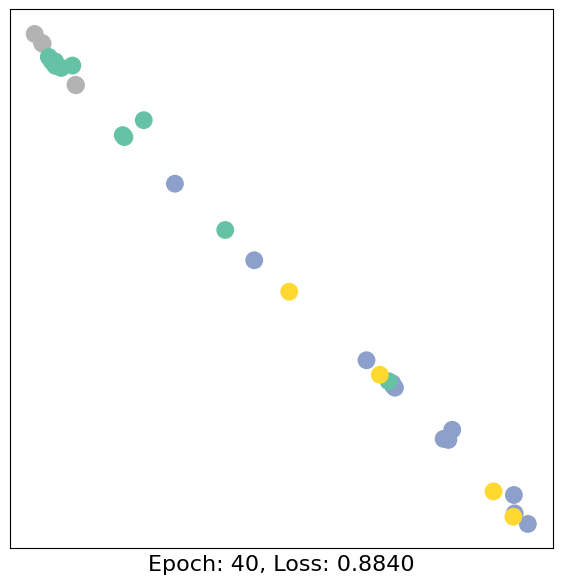

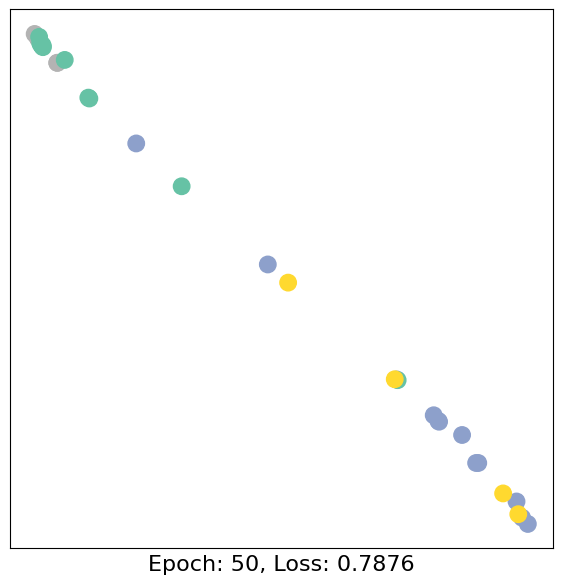

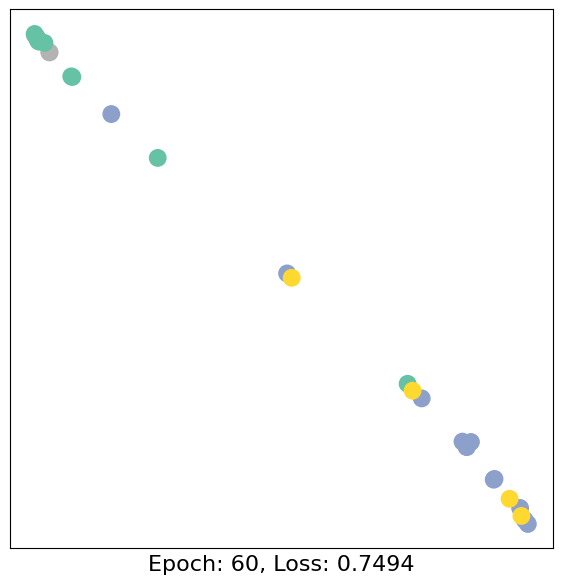

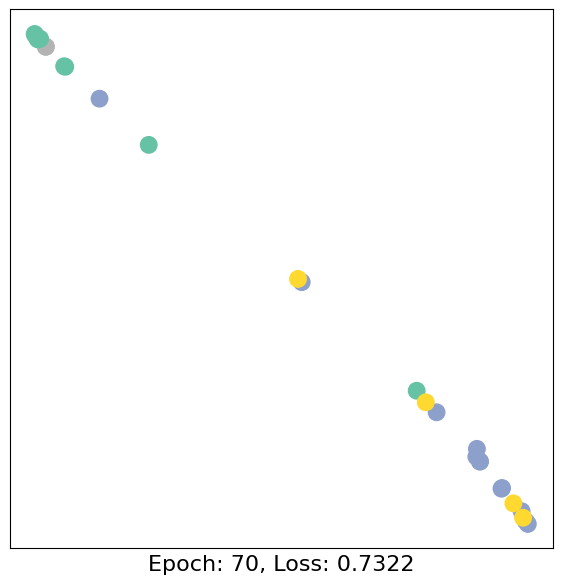

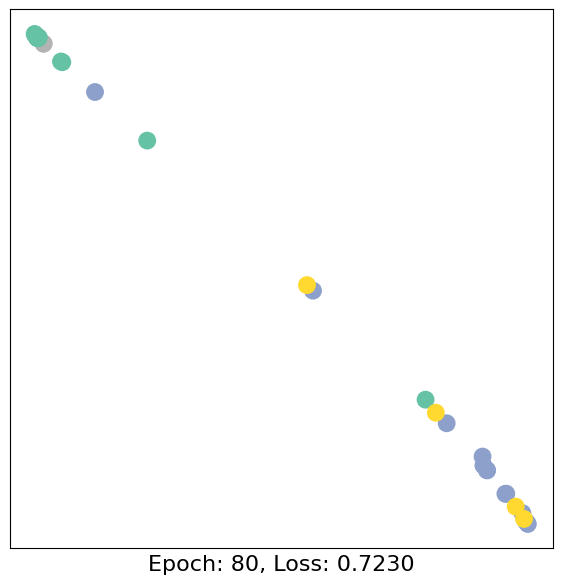

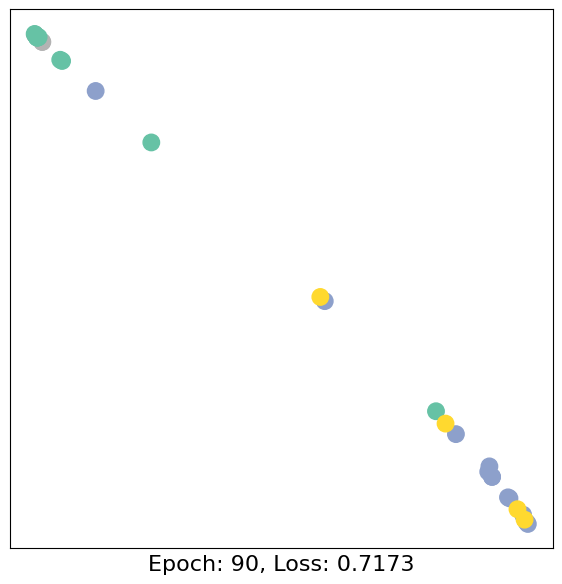

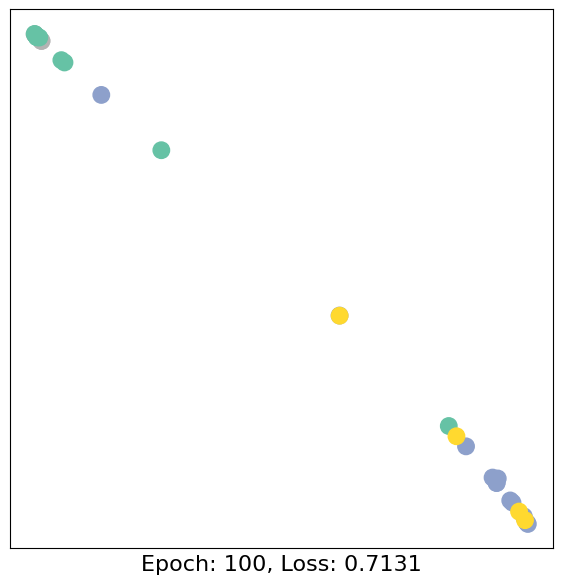

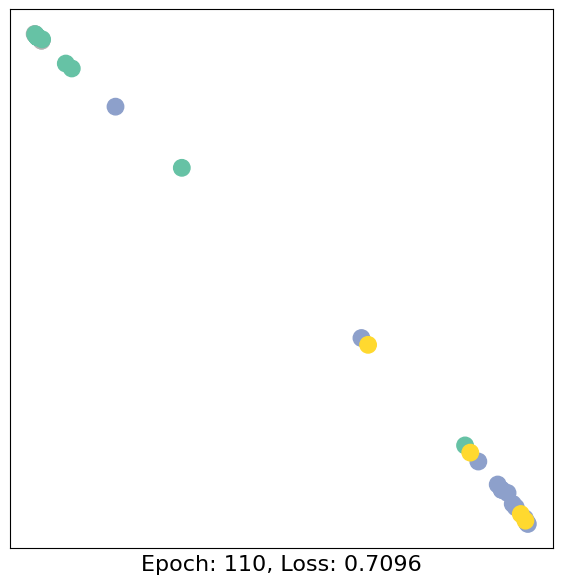

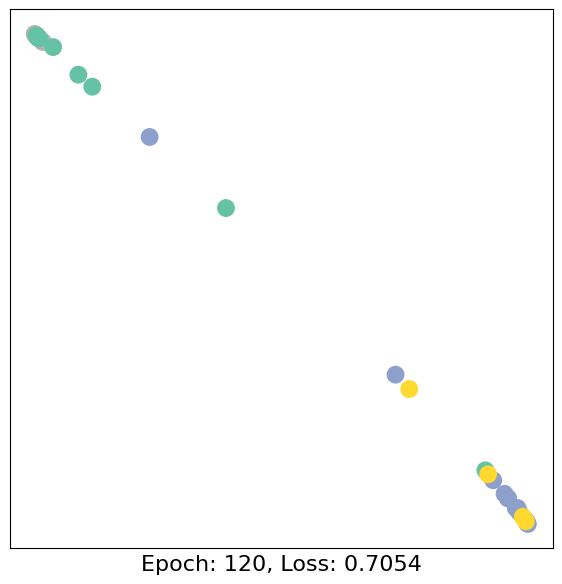

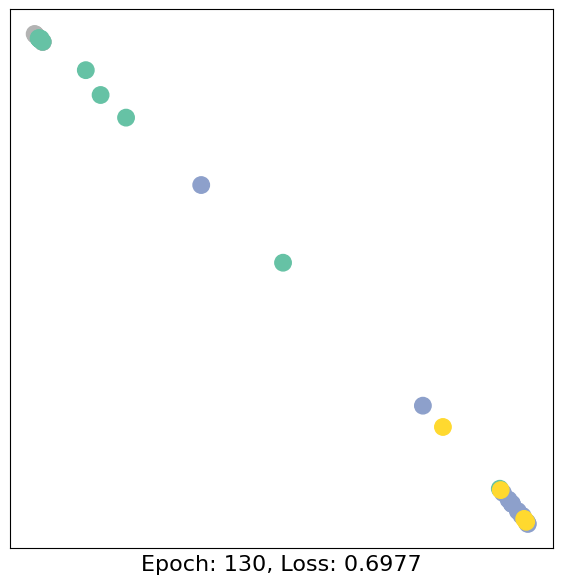

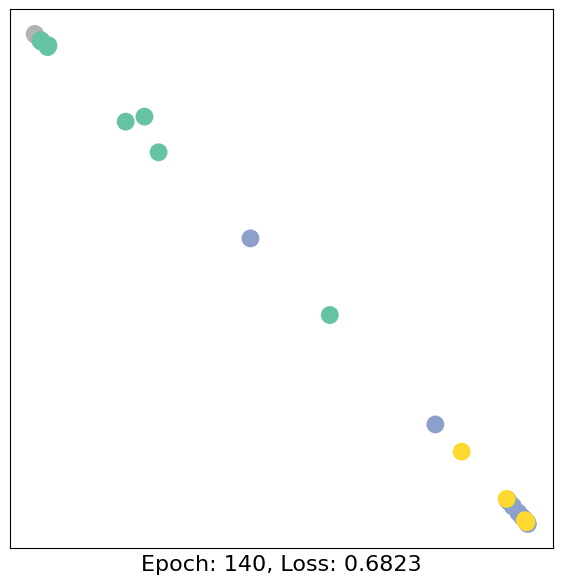

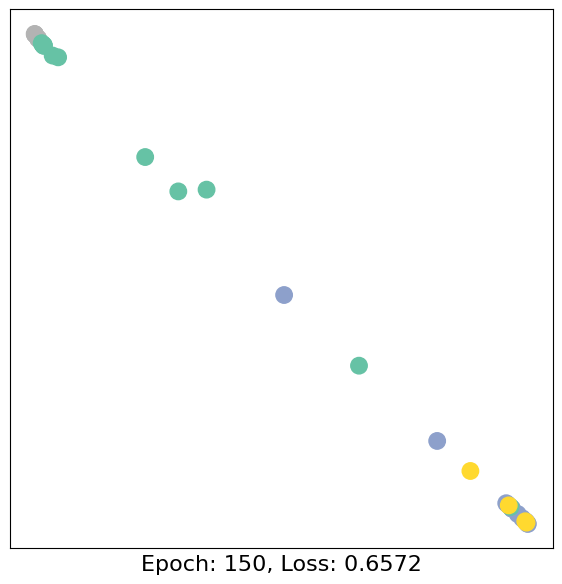

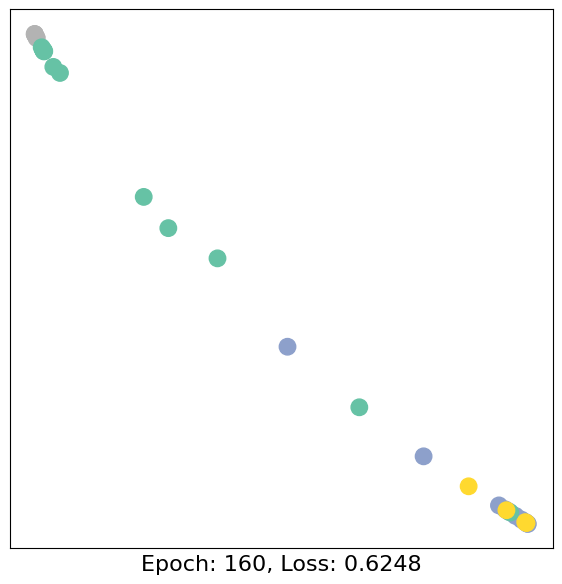

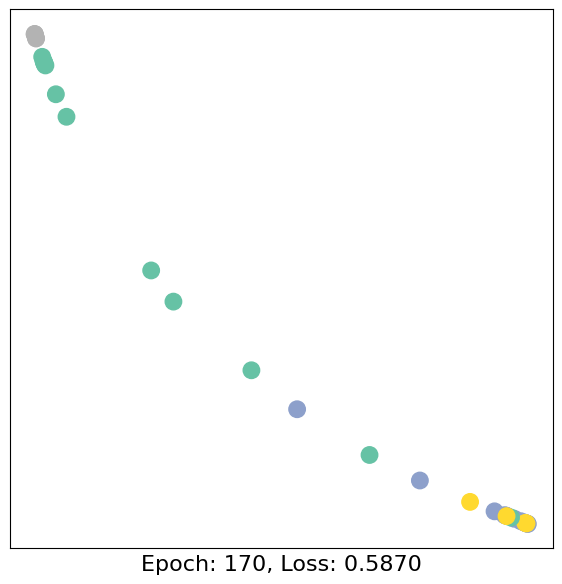

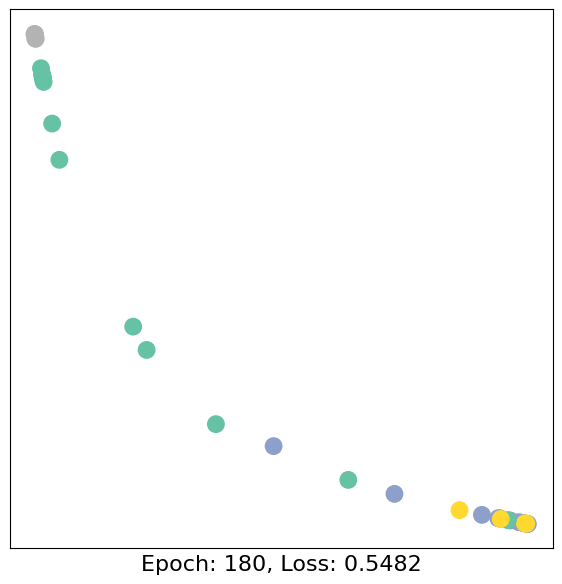

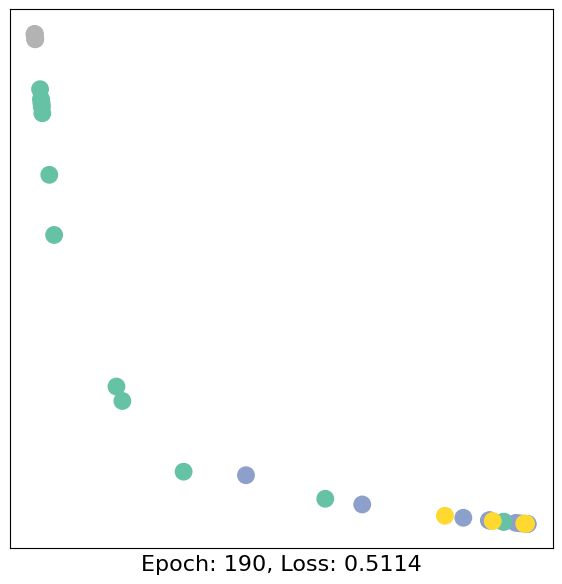

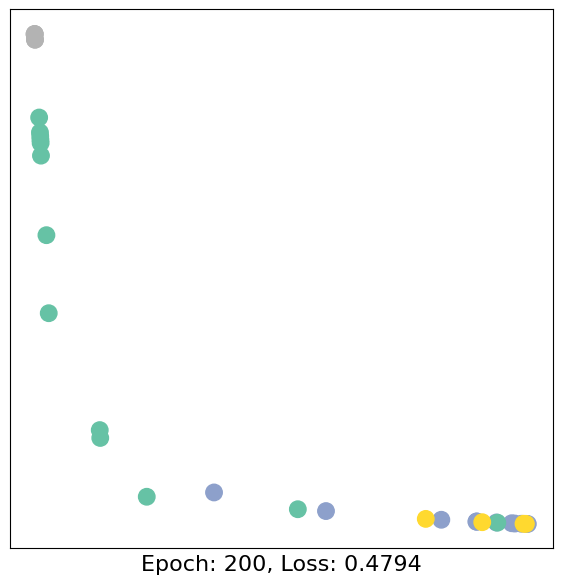

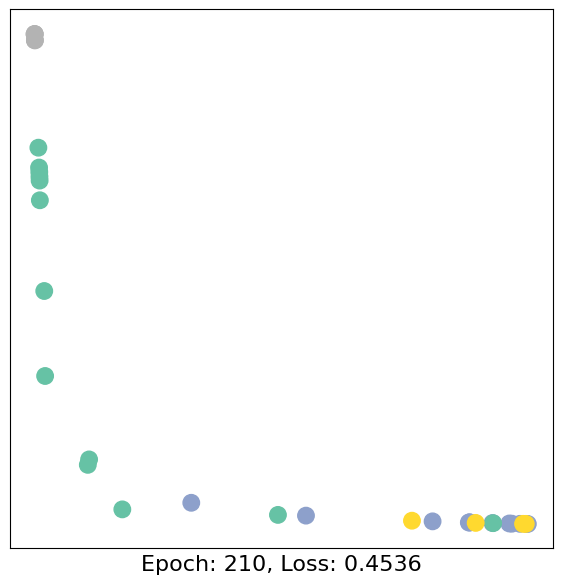

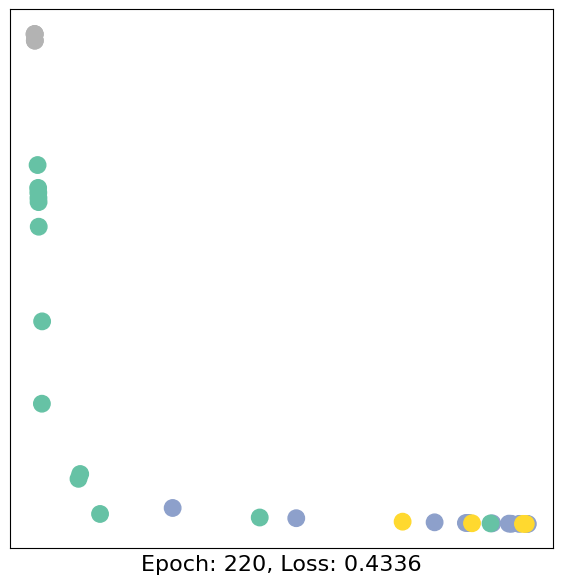

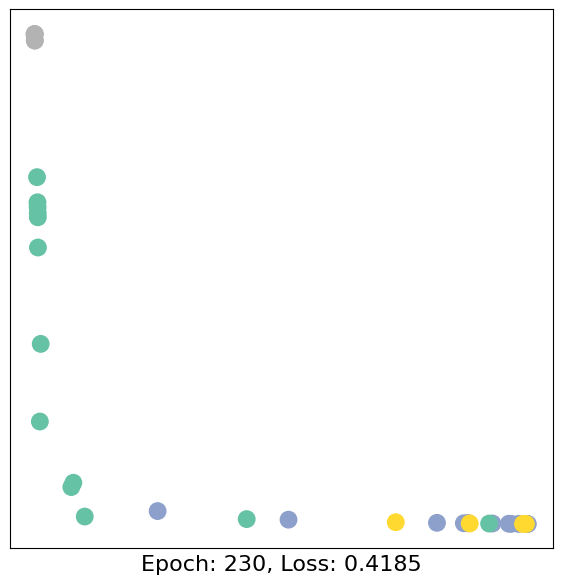

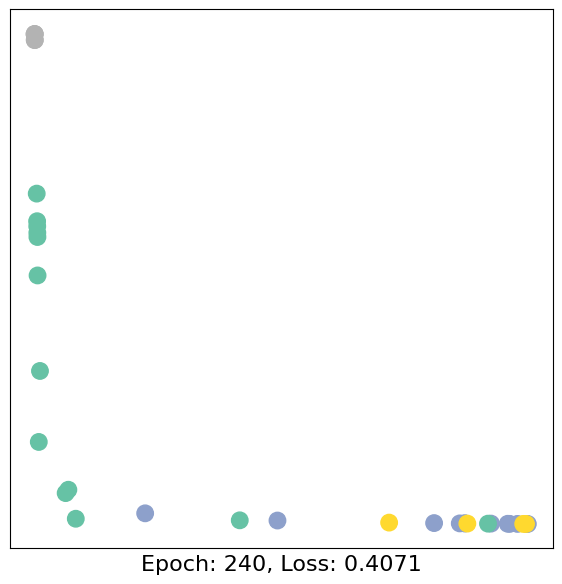

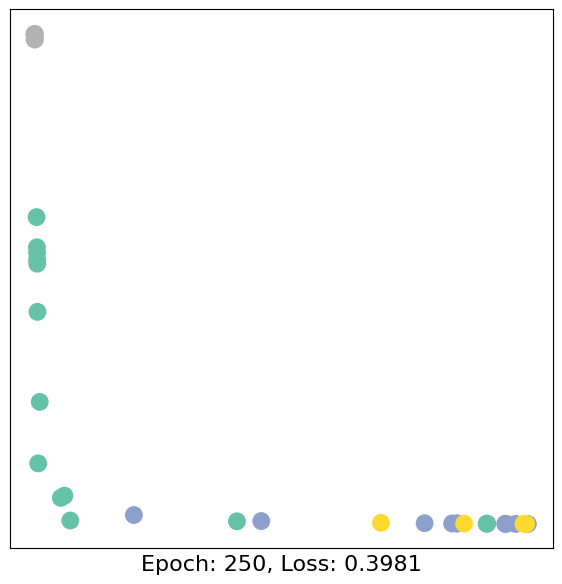

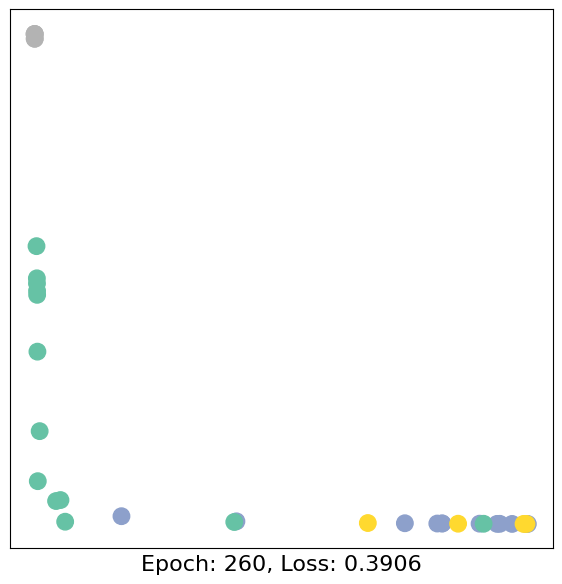

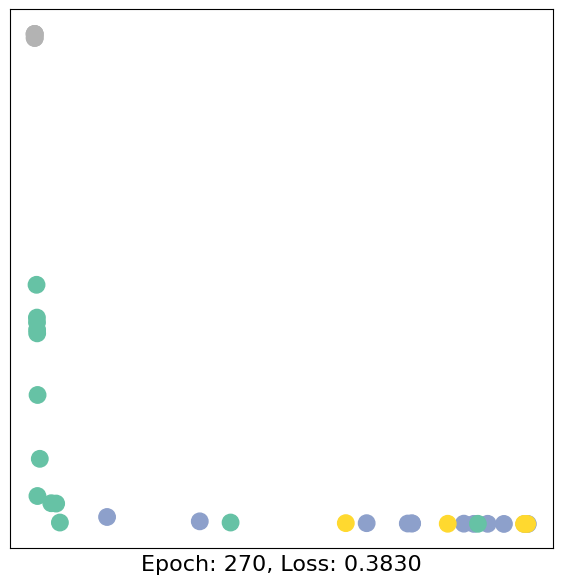

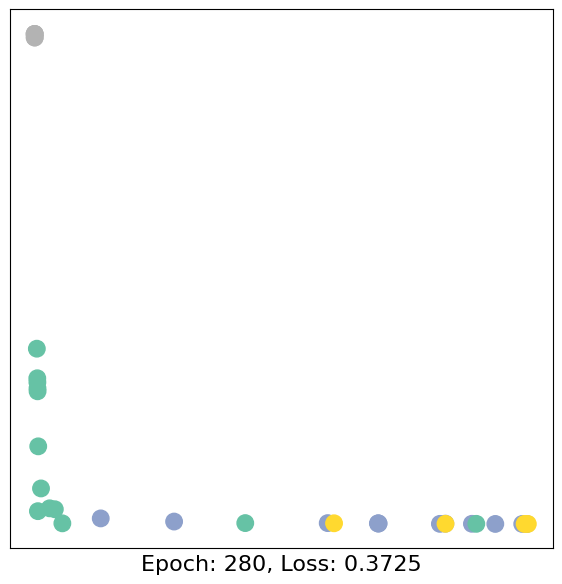

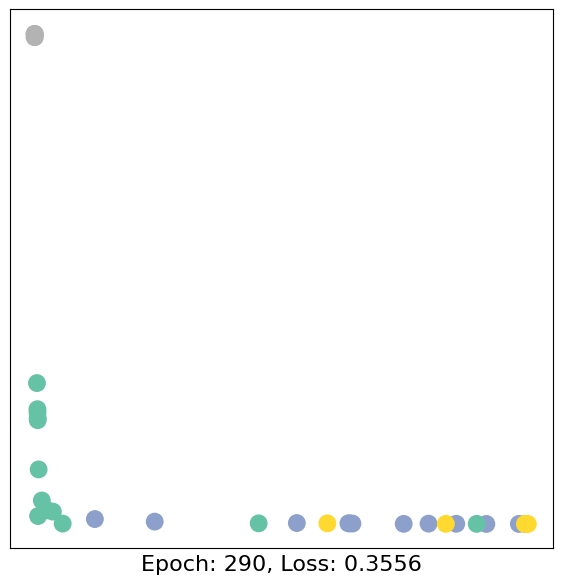

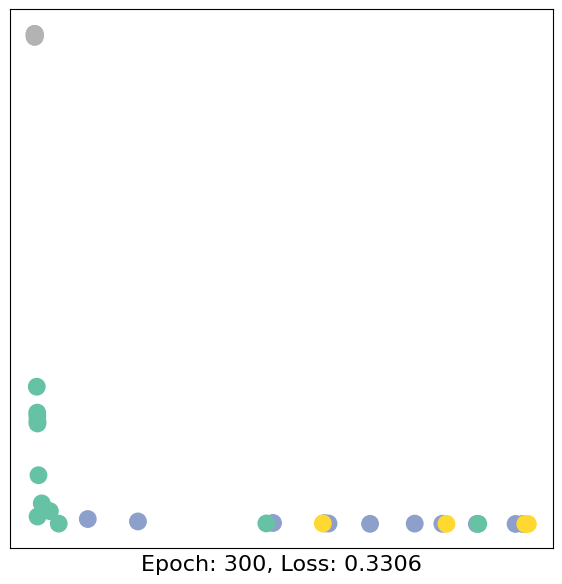

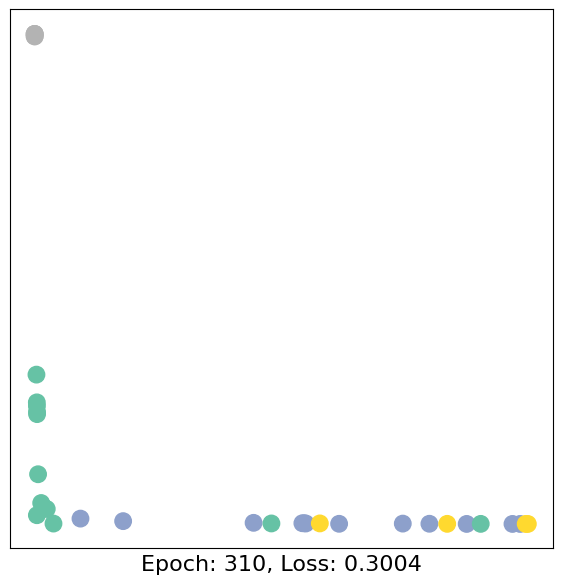

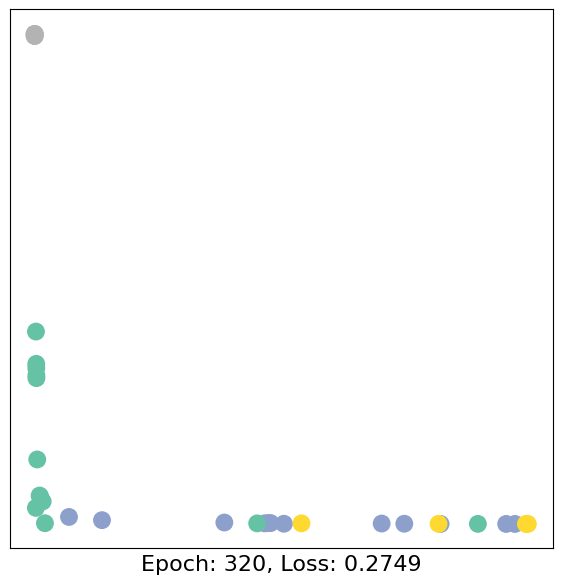

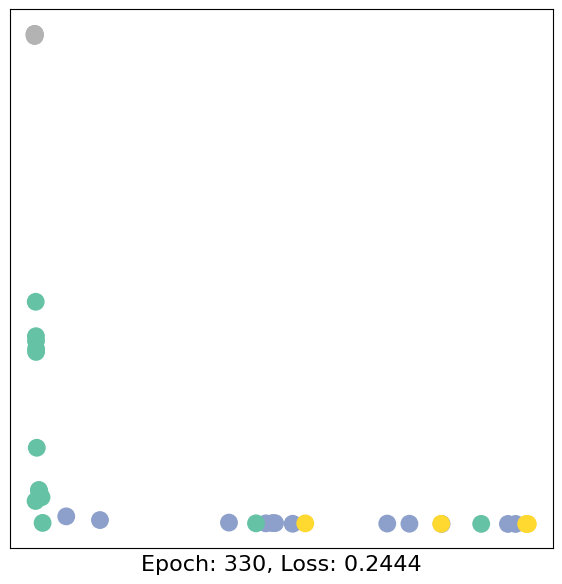

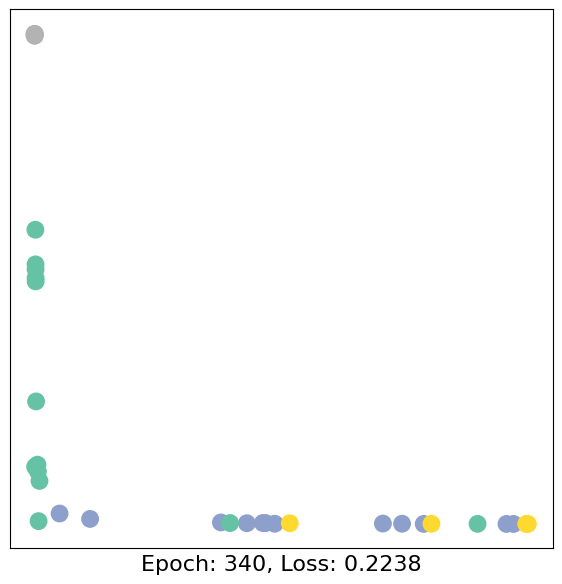

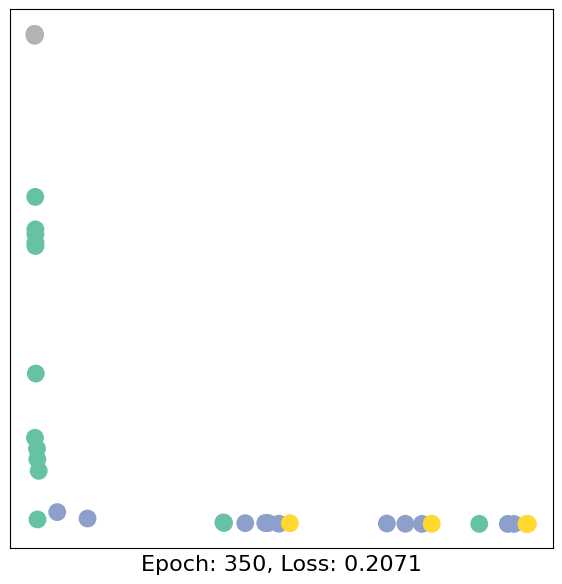

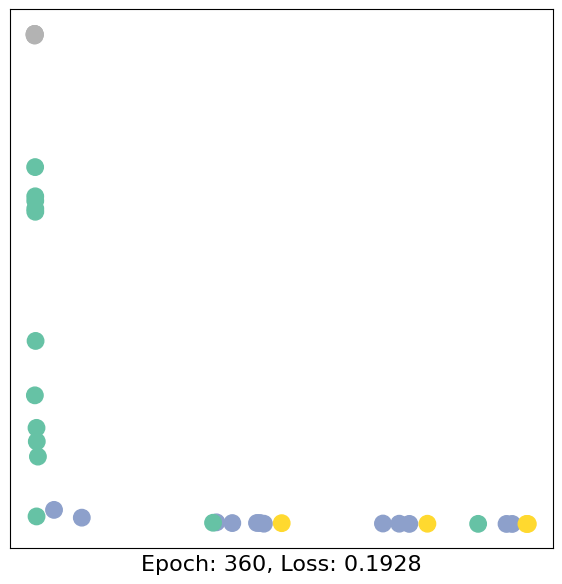

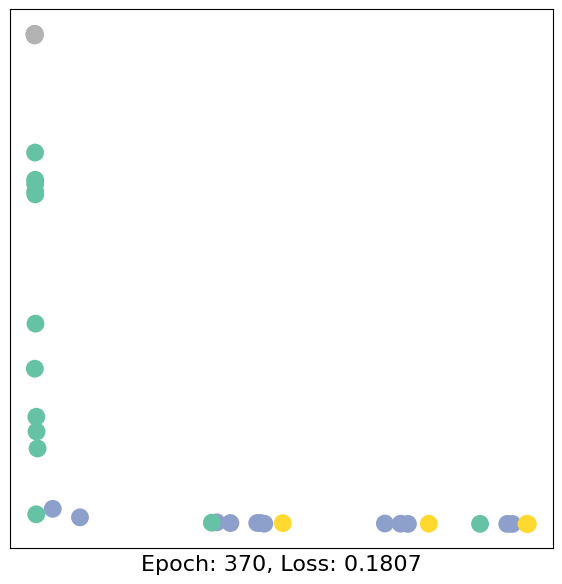

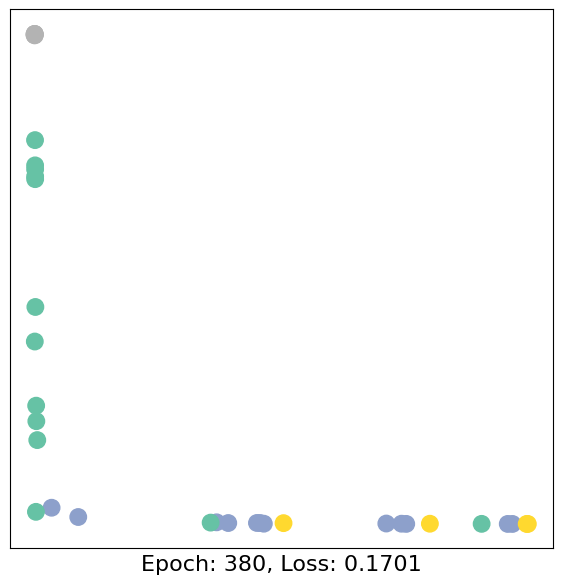

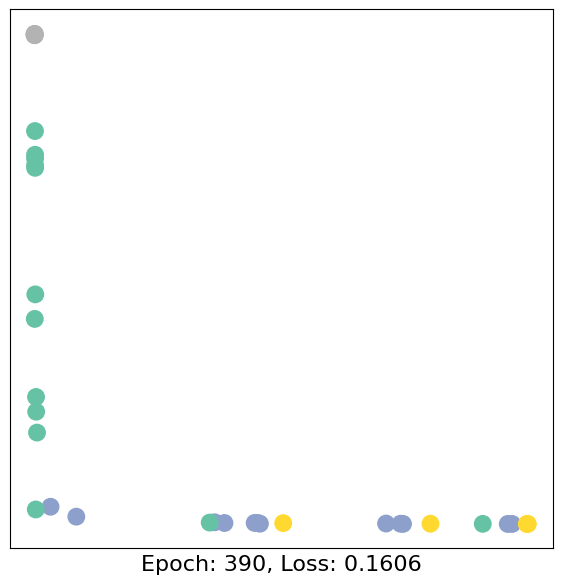

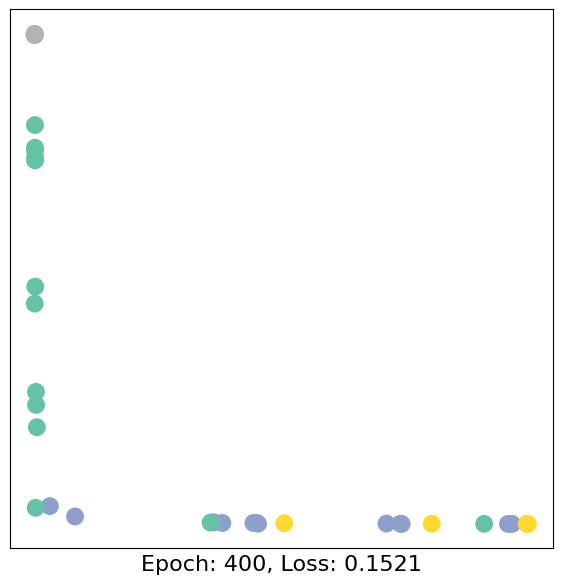

In [11]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

**Question :** Qu'observez-vous ?

Notre GCN de 3 couches parvient à séparer linéairement les communautés et à classer la plupart des nœuds efficacement.
Remarquez aussi la concision du code, grâce à l'usage de PyTorch Geometric, qui gère les données et propose des implémentations de GNN.

## Classification de nœuds avec un GNN

Nous allons maintenant utiliser un GNN pour effectuer une autre tâche de classification de sommets.
Toujours en possession d'une information sur un sous-ensemble de sommets, nous allons essayer d'inférer les étiquettes des autres sommets.

Nous allons travailler avec les données `Cora`, un réseau de citations ([Yang et al. (2016)](https://arxiv.org/abs/1603.08861)), où les nœuds sont des articles de recherche. L'article A est connecté à l'article B s'il le cite. Chaque nœud est décrit par un vecteur de caractéristiques de dimension 1433 (à partir d'un modèle _bag of words_). Il y a 7 catégories de documents. Les données Cora sont disponibles dans un sous-package de PyG, [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid).

In [12]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Ce dataset ressemble un peu à celui du Karaté Club, mais il est plus gros : 2708 sommets, 10556 arêtes, avec un degré moyen de 3.9. On dispose de la vérité terrain pour 140 nœuds, 20 par classe.

Toutefois, on dispose cette fois de deux données supplémentaires, `val_mask` et `test_mask`, qui indiquent les nœuds que l'on utilisera pour le test et la validation.

Avant de passer les données à notre GNN, on va aussi utiliser une procédure de [data transformation](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) avec `transform=NormalizeFeatures()`, pour normaliser les bag-of-words de nos vecteurs d'entrée.

### Entraînement d'un Multi-Layer Perceptron (MLP)

Nous devrions être en mesure d'inférer la catégorie d'un document seulement à l'aide de son contenu, c'est-à-dire des _bag of words_. Voyons ce qu'il en est avec un MLP, qui n'utilisera que cette information et des poids partagés entre tous les nœuds.

In [13]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Ce MLP est défini par deux couches linéaires, une [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) (pour l'activation) et un [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout). On réduit d'abord la dimension de 1433 à 16 (`hidden_channels=16`), puis on affecte dans les 7 classes (2e couche linéaire).

Entraînons ce MLP avec l'entropie croisée et Adam, comme précédemment. On se munit cette fois d'une fonction de test pour évlauer comment notre modèle se comporte sur les données de _test_.

In [14]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(200):
    loss = train()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


Calculons la justesse (_accurracy_) de nos prédictions sur les données de test :

In [15]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


**Question :** Que pensez-vous de ce chiffre ?

Ce MLP a une performance assez moyenne, avec seulement 59% d'*accuracy* (en test). Le sur-apprentissage est fort, provenant du faible nombre de nœuds utilisés pour l'apprentissage : la capacité de généralisation est limitée.

Le modèle ne tient pas non plus compte d'un biais important : les papiers cités sont souvent dans la même catégorie que le document initial. Les GNN devraient pouvoir améliorer cette performance.

### Entraînement d'un GNN

On peut passer de notre MLP à un GNN en échangeant les couches linéaires par des couches GNN. Essayons, comme précédemment, de travailler avec la couche [`GCN/GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv).

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

où $\mathbf{W}^{(\ell + 1)}$ est la matrice de poids apprise, de dimensions `[num_output_features, num_input_features]` et $c_{w,v}$ est un coefficient de normalisation fixé pour chaque arête.

Par contraste, une couche linéaire se définit comme suit :

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

Dans celle-ci, il n'y a aucune prise en compte de l'information du voisinage.

#### Implémentation

In [16]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


#### Visualisation avant l'entraînement

Regardons les embeddings de notre réseau _avant_ l'entraînement. Pour cela, nous utilisons un [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), permettant de visualiser nos embeddings de dimension 7 dans le plan.

In [17]:
from sklearn.manifold import TSNE

def visualize_tsne(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

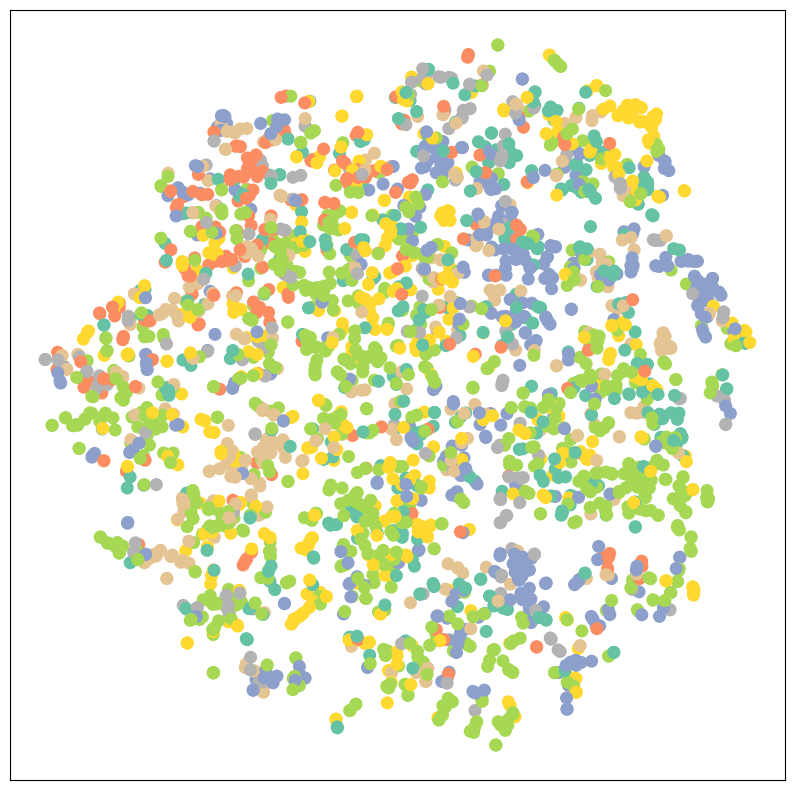

In [18]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize_tsne(out, color=data.y)

**Question :** Qu'observez-vous ?

Il y a *un peu* de clustering, au moins pour les nœuds "bleus". On va cependant tâcher d'améliorer ça avec l'entraînement. Pour cela, on va cette fois utiliser les attributs des nœuds (dans `x`) et les informations sur les arêtes (`edge_index`).

#### Entraînement

Nous allons maintenant entraîner le modèle, comme précédemment, en utilisant `x` et `edge_index` (pour utiliser l'information structurelle).

In [19]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9412
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9308
Epoch: 005, Loss: 1.9216
Epoch: 006, Loss: 1.9137
Epoch: 007, Loss: 1.9078
Epoch: 008, Loss: 1.8986
Epoch: 009, Loss: 1.8868
Epoch: 010, Loss: 1.8825
Epoch: 011, Loss: 1.8701
Epoch: 012, Loss: 1.8614
Epoch: 013, Loss: 1.8486
Epoch: 014, Loss: 1.8323
Epoch: 015, Loss: 1.8344
Epoch: 016, Loss: 1.8186
Epoch: 017, Loss: 1.8031
Epoch: 018, Loss: 1.7980
Epoch: 019, Loss: 1.7813
Epoch: 020, Loss: 1.7766
Epoch: 021, Loss: 1.7478
Epoch: 022, Loss: 1.7385
Epoch: 023, Loss: 1.7304
Epoch: 024, Loss: 1.7120
Epoch: 025, Loss: 1.7010
Epoch: 026, Loss: 1.6917
Epoch: 027, Loss: 1.6672
Epoch: 028, Loss: 1.6382
Epoch: 029, Loss: 1.6474
Epoch: 030, Loss: 1.6297
Epoch: 031, Loss: 1.6014
Epoch: 032, Loss: 1.5760
Epoch: 033, Loss: 1.5732
Epoch: 034, Loss: 1.5705
Epoch: 035, Loss: 1.5443
Epoch: 036, Loss: 1.5131
Epoch: 037, Loss: 1.4721
Epoch: 038, Loss: 1.4774
Epoch: 039, Loss: 1.4380
Epoch: 040, Loss: 1.4553


In [20]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8080


**Question :** Que pensez-vous de ce résultat ?

En échangeant simplement des couches linéaires avec des GNN, on atteint 81.4% en *accuracy*. De façon prévisible, l'information sur les arêtes a permis d'augmenter significativement les performances.

#### Visualisation après entraînement

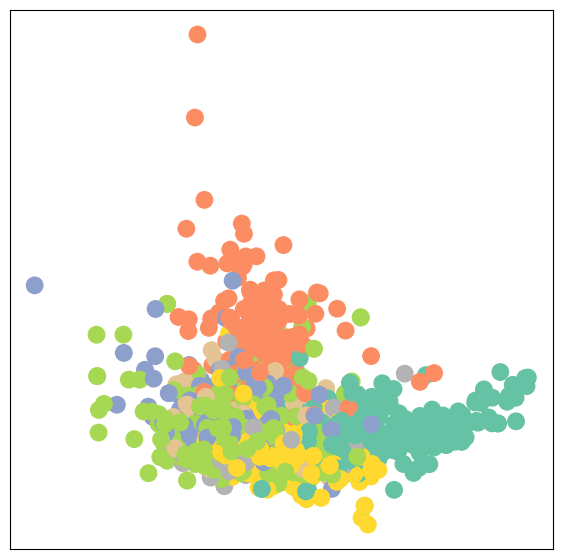

In [21]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Bonus

1. Pour améliorer les performances en évitant le sur-apprentissage, on sélectionne en général un modèle en regardant les performances sur un jeu de validation. Nous n'avons pas utilisé `data.val_mask`. Essayez de modifier le code pour sélectionner le modèle avec la meilleure performance sur cet ensemble. Vous devriez ensuite parvenir avec ce modèle à une performance proche de 82% sur les données de test.

2. Essayez de voir comment se comporte le GCN quand on change la dimension cachée ou le nombre de couches ? Cela améliore-t-il les performances ?